In [2]:
# 필요한 패키지 모두 import #
import os
import random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier 
#LGBM 사용할 예정
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

plt.rc('font', family='NanumBarunGothic')

## LGBM이란?
- 결정트리의 과적합 문제를 해결코자 나온 앙상블 방식 중 하나
- Boosting 방법을 사용한 것 중 하나인 LightGBM은 XGBoost와 함께 회귀, 분류 문제에서 자주 사용되는 머신러닝 알고리즘임.
    - Boosting 방식이란 성능이나 기능이 안 좋은 모델(Weak model)들을 골라서 단점을 보완하여 \
        학습을 할 수록 성능이 좋은 모델들을 만들고 성능이 좋은 모델들의 예측만을 종합하는 것
- XGBoost와 비교해서 성능 차이를 그렇게 많이 보이지 않으면서 학습 속도를 빠르게 올린 모델이다.
- 10000건 이하의 데이터 셋에는 과적합이 발생한다는데, 현재 train set에서는 약 2만개의 데이터가 존재하므로 과적합 문제를 덜어놓고 진행했다.

In [3]:
#데이콘 Basic 음악 장르 분류 AI 경진대회
#https://dacon.io/competitions/official/236056/data
#데이터 로드 및 확인
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

In [4]:
train.head(3)

,ID,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration,genre
0,TRAIN_00000,0.3341,0.9231,10,0.8540,0.3797,0.008,0.0002,0.7697,0.7902,0.5391,175,trap
1,TRAIN_00001,0.6344,0.5955,10,0.2826,0.1378,0.000,0.7137,0.1597,0.4162,0.3043,513,techno
2,TRAIN_00002,0.3983,0.1107,8,0.2459,0.0247,0.774,0.0000,0.5105,0.4291,0.2324,151,Trap Metal


## 랜덤시드 고정

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(52) # Seed 고정

## EDA

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25383 entries, 0 to 25382
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                25383 non-null  object 
 1   danceability      25383 non-null  float64
 2   energy            25383 non-null  float64
 3   key               25383 non-null  int64  
 4   loudness          25383 non-null  float64
 5   speechiness       25383 non-null  float64
 6   acousticness      25383 non-null  float64
 7   instrumentalness  25383 non-null  float64
 8   liveness          25383 non-null  float64
 9   valence           25383 non-null  float64
 10  tempo             25383 non-null  float64
 11  duration          25383 non-null  int64  
 12  genre             25383 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 2.5+ MB


In [7]:
train.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration
count,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000,25383.000000
mean,0.544519,0.642106,5.368239,0.523904,0.271701,0.178736,0.309931,0.324461,0.403999,0.503558,253.697514
std,0.242362,0.275050,3.660011,0.209811,0.276586,0.272155,0.399725,0.254626,0.286148,0.222104,103.020340
min,0.000000,0.000000,0.000000,0.000000,0.001100,0.000000,0.000000,0.000000,0.000000,0.007300,28.000000
25%,0.340500,0.410000,1.000000,0.372900,0.062950,0.003700,0.000000,0.138100,0.148000,0.322350,182.000000
50%,0.553400,0.701300,6.000000,0.538300,0.129600,0.035800,0.006500,0.200700,0.361800,0.483500,227.000000
75%,0.759900,0.895700,9.000000,0.683600,0.450200,0.237500,0.814000,0.501500,0.640800,0.659350,304.000000
max,1.000000,1.000000,11.000000,0.999500,1.000000,0.999900,1.000000,1.000000,1.000000,1.000000,897.000000


In [8]:
train.dtypes

ID                   object
danceability        float64
energy              float64
key                   int64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration              int64
genre                object
dtype: object

In [9]:
pd.set_option('display.max_rows', None) # 전체 행 보이기

In [10]:
#결측치가 없음을 EDA 파일을 통해 확인했고, 간단히 그래프를 만들어 장르별 'key'의 분포가 다르게 나타나는지 확인하고자 한다.
pd.DataFrame(train.groupby('genre')['key'].value_counts())

key
genre           key     
Dark Trap       1    461
                8    276
                9    242
                0    238
                6    235
                7    218
                10   216
                11   201
                2    196
                5    187
                4    145
                3     81
Emo             1    124
                0    111
                2    111
                4     96
                6     93
                7     84
                9     84
                11    70
                5     69
                8     66
                10    52
                3     39
Hiphop          1    333
                11   182
                7    176
                10   176
                6    156
                2    148
                8    140
                0    132
                9    123
                4    105
                5    104
                3     47
Pop             1     35
                7     32
                0     31
                5     31
                11    27
                8     25
                9     22
                6     18
                4     16
                10    16
                2     12
                3      5
Rap             1    248
                10   105
                8     96
                7     95
                2     91
                0     89
                11    82
                6     76
                9     76
                5     73
                4     69
                3     20
RnB             1    226
                0    148
                8    139
                5    107
                7    107
                6    106
                11   104
                9     98
                2     90
                10    78
                4     73
                3     32
Trap Metal      1    317
                0    116
                8    110
                2     98
                10    98
                7     89
                11    78
                5     76
                9     70
                6     65
                4     52
                3     19
Underground Rap 1    780
                8    331
                10   321
                11   296
                0    292
                2    280
                6    265
                7    244
                9    238
                5    211
                4    178
                3     46
dnb             1    268
                5    201
                10   182
                8    177
                6    149
                0    138
                11   137
                7    136
                9    129
                2    109
                4     97
                3     26
hardstyle       5    228
                9    225
                1    205
                7    167
                11   167
                6    149
                0    144
                10   134
                8    113
                4     92
                2     81
                3     50
psytrance       7    359
                6    262
                11   262
                1    226
                9    135
                0    104
                8     92
                2     91
                4     78
                10    77
                5     70
                3     11
techhouse       11   284
                1    255
                6    202
                0    174
                7    174
                9    148
                8    119
                10   119
                2    108
                5    107
                4     87
                3     32
techno          7    351
                1    304
                11   222
                6    175
                2    126
                10   120
                4    113
                8    102
                0    100
                9     75
                5     63
                3     16
trance          6    218
                7    208
                1    

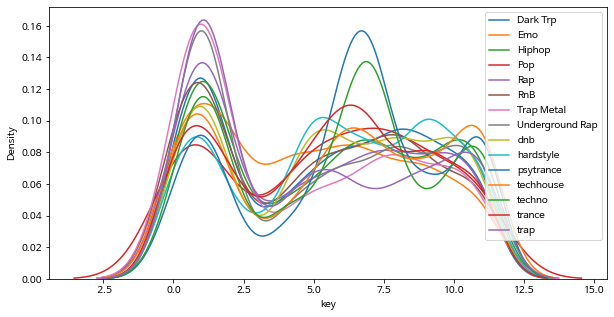

In [11]:
#장르마다 주요로 사용되는 'key'가 다름을 알 수 있다.
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.kdeplot(x=train[train.genre == 'Dark Trap']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'Emo']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'Hiphop']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'Pop']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'Rap']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'RnB']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'Trap Metal']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'Underground Rap']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'dnb']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'hardstyle']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'psytrance']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'techhouse']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'techno']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'trance']['key'], ax=ax)
sns.kdeplot(x=train[train.genre == 'trap']['key'], ax=ax)


plt.legend(['Dark Trp', 'Emo', 'Hiphop', 'Pop', 'Rap', 'RnB', 'Trap Metal', 'Underground Rap', 'dnb'\
           , 'hardstyle', 'psytrance', 'techhouse', 'techno', 'trance', 'trap'])

plt.show()

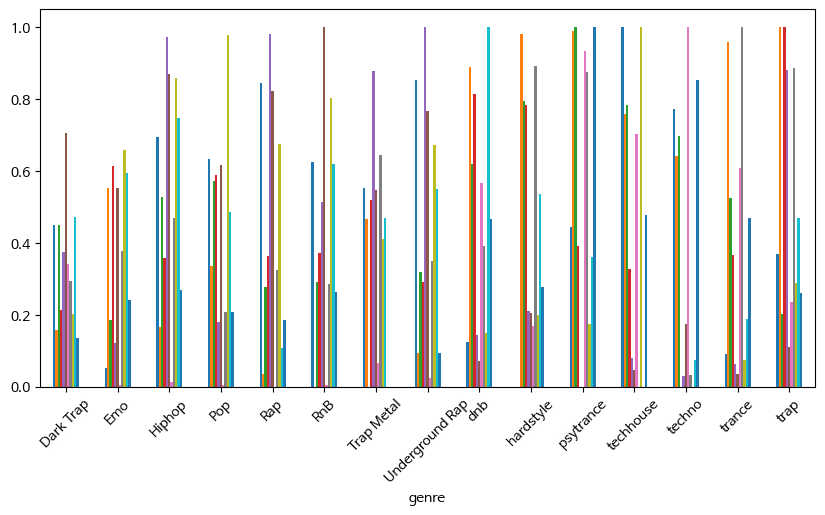

In [17]:
from sklearn.preprocessing import MinMaxScaler #모든 데이터를 0과 1사이에 위치하게끔 전처리한 뒤, 간단히 그래프를 만들었다.

fig, ax = plt.subplots(figsize = (10,5), dpi = 100)

scaler = MinMaxScaler()
temp = train.groupby(by='genre').mean()
temp[train.groupby(by='genre').mean().columns] = scaler.fit_transform(train.groupby(by='genre').mean())

temp.plot(kind='bar', legend=False , ax = ax)
plt.xticks(rotation = 45)
plt.show()

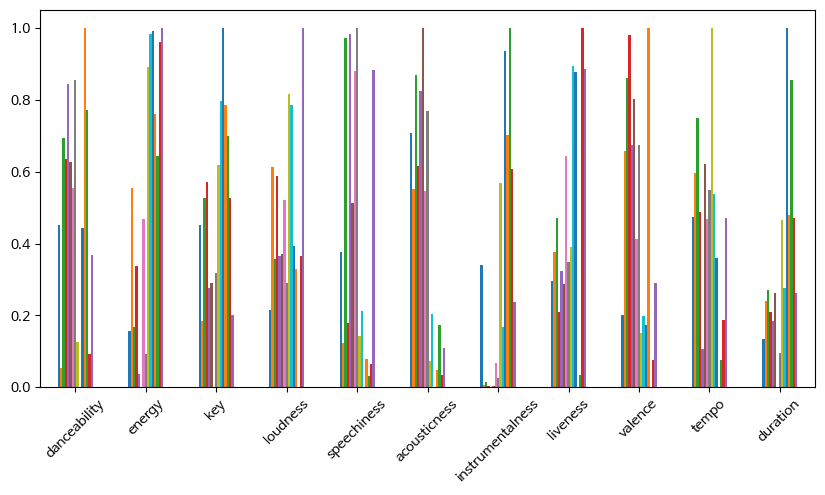

In [18]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 100)
temp.T.plot(kind='bar', legend=False , ax = ax)
plt.xticks(rotation = 45)
plt.show()

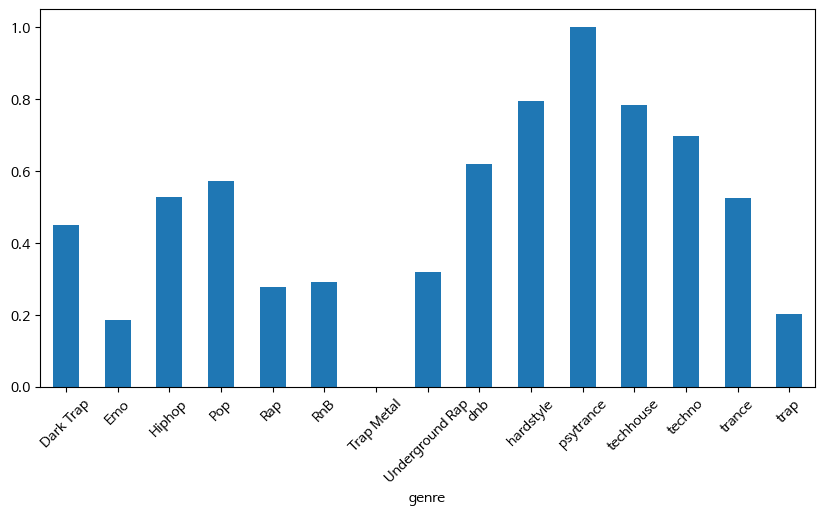

In [24]:
fig, ax = plt.subplots(figsize = (10,5), dpi = 100)
temp.key.plot(kind='bar', legend=False , ax = ax)
plt.xticks(rotation = 45)
plt.show()
#key 별로 차이가 있음을 확인. 
#해당 분석으로 주성분 분석 및 차원축소를 적용해보고 싶었으나, 역량이 부족해서 실천하지 못했음. 다음 모델링에서 시도해보고자 함.
#heatmap과 연결시켜 진행하는 것으로 보임.

## 독립변수(X), 종속변수(y)로 나누기

In [25]:
X = train.drop(["ID", "genre"], axis = 1) #열 기준으로 id와 genre 제거
y = train[['genre']] # 장르만 가져오기
test = test.drop(["ID"], axis = 1) #id 제거

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2) 
#8:2 비율로 train set과 valid set을 분리했음. test 데이터는 결과 제출용

## 모델링 : LGBM

In [29]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)


In [32]:
model = LGBMClassifier(n_estimators=400, learning_rate = 0.05) 
#LGBM의 하이퍼 파라미터 중 n_estimators와 learning_rate은 
#전자는 "몇 개의 모델을 합칠 건지 지정"하고
#후자는 학습률이며, 모델이 최적화되는(최적해에 접근하는) 과정에서 
#learning_rate만큼 이동시키면서 최적해에 도달한다.
#경사하강법에 관련된 개념으로 이해하면 된다.

#사이킷런 래퍼 LIghtGBM을 사용했음.
#파이썬 래퍼 LightGBM은 하이퍼파라미터의 명칭이 다른 경우가 존재함.

evals = [(X_train, y_train), (X_valid, y_valid)] 
#eval_set에 들어갈 내용으로, n_estimators만큼 반복적으로 학습을 수행할 때마다 
#얼마나 성능이 향상되었는지 X_valid, y_valid를 검증데이터로 인식 및 검증케함.

In [33]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : evals,
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': True,
            'categorical_feature': 'auto'}
model.fit(X_train,y_train, **fit_params)
###GBM은 여러 개의 estimator가 순차적으로 오류를 개선하면서 weight을 update하는 방식
###그래서 estimator를 재학습하고 검증 데이터로 다시 오류를 산출하여 평가함
###이 과정에서 eval_set 속 evals가 필요한 것!

##eval_set은 검증 세트를 지정하는 파라미터.
##학습은  (X_train, y_train), 검증은 (X_test, y_test) 데이터 세트를 이용하라는 것
##eval_set = [(X_valid, y_valid)]라는 코드가 저 명확하긴 함.
##저자는 데이터가 적다면 valid 데이터 대신 test 값을 사용한다고 하는데, 
##이 경우 data leakage에 해당하는 것 같아 주의 필요.



##early_stopping_round : validation(검증) 데이터 셋에서 평가 지표가 더이상
##향상되지 않으면 정지함. 평가지표의 향상이 n round 이상 지속되면 학습을 정지한다.

##eval_metric : 검증데이터로 loss 측정 시에 사용하는 방법
## logloss는 이진 분류에 사용된다.
## 해당 대회를 위해서라면 eval_metric에 f1_score를 최대화시키는 함수를 만들어
## 함수를 삽입할 수 있다.
### 참고 : https://www.inflearn.com/questions/344831/lightgbm-eval-metric-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4


##verbose : verbose가 있으면 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 
##자세히 내보낼 것인가를 나타냄.
##보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태

valid_pred = model.predict(X_valid)
#valid data를 예측한 모델 값을 valid_pred 변수에 할당
print("현재 Macro F1 Score의 검증 점수는 {}입니다.".format(f1_score(valid_pred, y_valid, average = "macro"))) 
#macro f1-score 값을 valid 데이터로 확인해봤음.

[1]	training's multi_logloss: 2.28453	training's macroF1: 0.320314	valid_1's multi_logloss: 2.30102	valid_1's macroF1: 0.306181
Training until validation scores don't improve for 50 rounds
[2]	training's multi_logloss: 2.08198	training's macroF1: 0.542977	valid_1's multi_logloss: 2.115	valid_1's macroF1: 0.509943
[3]	training's multi_logloss: 1.92919	training's macroF1: 0.602563	valid_1's multi_logloss: 1.97599	valid_1's macroF1: 0.557405
[4]	training's multi_logloss: 1.80596	training's macroF1: 0.635118	valid_1's multi_logloss: 1.86347	valid_1's macroF1: 0.586054
[5]	training's multi_logloss: 1.70264	training's macroF1: 0.654548	valid_1's multi_logloss: 1.76967	valid_1's macroF1: 0.599254
[6]	training's multi_logloss: 1.61446	training's macroF1: 0.669257	valid_1's multi_logloss: 1.68948	valid_1's macroF1: 0.608087
[7]	training's multi_logloss: 1.53689	training's macroF1: 0.680551	valid_1's multi_logloss: 1.62011	valid_1's macroF1: 0.613285
[8]	training's multi_logloss: 1.46846	trainin

[66]	training's multi_logloss: 0.565024	training's macroF1: 0.817513	valid_1's multi_logloss: 0.899001	valid_1's macroF1: 0.654444
[67]	training's multi_logloss: 0.56087	training's macroF1: 0.819524	valid_1's multi_logloss: 0.897681	valid_1's macroF1: 0.654586
[68]	training's multi_logloss: 0.556955	training's macroF1: 0.820795	valid_1's multi_logloss: 0.896552	valid_1's macroF1: 0.654786
[69]	training's multi_logloss: 0.553111	training's macroF1: 0.822927	valid_1's multi_logloss: 0.895736	valid_1's macroF1: 0.65476
[70]	training's multi_logloss: 0.549428	training's macroF1: 0.824541	valid_1's multi_logloss: 0.894712	valid_1's macroF1: 0.654245
[71]	training's multi_logloss: 0.545667	training's macroF1: 0.825613	valid_1's multi_logloss: 0.893827	valid_1's macroF1: 0.655313
[72]	training's multi_logloss: 0.542072	training's macroF1: 0.826458	valid_1's multi_logloss: 0.893184	valid_1's macroF1: 0.655699
[73]	training's multi_logloss: 0.538491	training's macroF1: 0.828346	valid_1's multi_

[131]	training's multi_logloss: 0.397728	training's macroF1: 0.893448	valid_1's multi_logloss: 0.890215	valid_1's macroF1: 0.655792
[132]	training's multi_logloss: 0.396053	training's macroF1: 0.894262	valid_1's multi_logloss: 0.890286	valid_1's macroF1: 0.655673
[133]	training's multi_logloss: 0.39433	training's macroF1: 0.89501	valid_1's multi_logloss: 0.890561	valid_1's macroF1: 0.65627
[134]	training's multi_logloss: 0.39274	training's macroF1: 0.895551	valid_1's multi_logloss: 0.890683	valid_1's macroF1: 0.655246
[135]	training's multi_logloss: 0.391239	training's macroF1: 0.896168	valid_1's multi_logloss: 0.890946	valid_1's macroF1: 0.654931
Early stopping, best iteration is:
[85]	training's multi_logloss: 0.499653	training's macroF1: 0.846092	valid_1's multi_logloss: 0.885388	valid_1's macroF1: 0.659647
현재 Macro F1 Score의 검증 점수는 0.6596467022075775입니다.


In [34]:
pred = model.predict(test) #test 데이터를 모델로 예측한 값을 pred 변수에 저장

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

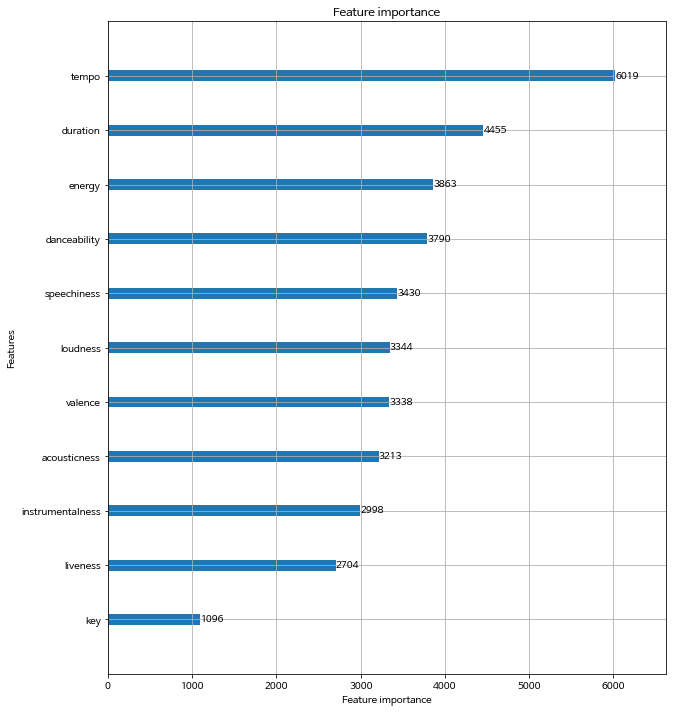

In [35]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax=ax) #light gbm 모델에서 중요하게 여기는 요소를 확인했음. key보다는 tempo가 중요했음.

In [36]:
submission = pd.read_csv("./sample_submission.csv") #sample 파일에 genre값에 모델로 test데이터를 예측한 값을 넣음
submission["genre"] = pred

In [37]:
submission #분류가 잘 되었는지 확인

,ID,genre
0,TEST_00000,Hiphop
1,TEST_00001,Underground Rap
2,TEST_00002,Emo
3,TEST_00003,techhouse
4,TEST_00004,Pop
5,TEST_00005,techno
6,TEST_00006,techno
7,TEST_00007,RnB
8,TEST_00008,Underground Rap
9,TEST_00009,Underground Rap


In [38]:
submission.to_csv("./submit.csv", index = False) #제출용 파일 만듦

## 참고문헌
- https://www.kaggle.com/code/subinium/kakr-eda/notebook  
- https://rfriend.tistory.com/262
- https://blog.naver.com/aattspa/222936681800
- https://data-marketing-bk.tistory.com/28
- https://blog.naver.com/heetae185/222646465288
- https://blog.naver.com/dmz04/222755852813
- https://www.inflearn.com/questions/27184/eval-set%EA%B0%80-%EB%AD%90%ED%95%98%EB%8A%94%EA%B1%B4%EA%B0%80%EC%9A%94
- https://greatjoy.tistory.com/72
- https://www.inflearn.com/questions/208344/verbose-%EC%9D%98%EB%AF%B8
- https://github.com/Microsoft/LightGBM/issues/1483
- https://www.inflearn.com/questions/344831/lightgbm-eval-metric-%EC%A7%88%EB%AC%B8%EC%9E%85%EB%8B%88%EB%8B%A4